# Librerías

In [1]:
import pandas as pd
from palette_creator import PaletteCreator, show_palette
from pathlib import Path
import cv2
import json

# Funciones auxiliares

In [2]:
class DataLoader:
    def __init__(self, file_list, batch_size, pre_process=None):
        self.batch_size = batch_size
        self.file_list = file_list
        self.num_samples = len(self.file_list)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size
        self.current_batch = 0
        self.pre_process = pre_process

    def __iter__(self):
        return self
    
    def load_img(self, path_img):
        path_img = str(path_img)

        # Check if path exists
        if not Path(path_img).exists():
            print(f"Path {path_img} doesn't exist")
            return None
        
        if self.pre_process is not None:
            return self.pre_process(cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB))
        
        return cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB)
    
    def __len__(self):
        return self.num_batches

    def __next__(self):
        if self.current_batch < self.num_batches:
            batch_start = self.current_batch * self.batch_size
            batch_end = (self.current_batch + 1) * self.batch_size
            batch_files = self.file_list[batch_start:batch_end]

            batch_images = [self.load_img(file) for file in batch_files]
            self.batch_size = len(batch_images)
            self.current_batch += 1
            return batch_images
        else:
            self.current_batch = 0
            raise StopIteration
        
    def __item__(self, index):
        if isinstance(index, slice):
            return [self.load_img(file) for file in self.file_list[index]]
        return self.load_img(self.file_list[index])
    
    def __getitem__(self, index):
        return self.__item__(index)

In [3]:
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def save_results_to_db(db, method, results): 
    palettes, proportions = results
    db[f"{method}_palette"], db[f"{method}_proportions"] = palettes, proportions
    db[f"{method}_palette"] = db[f"{method}_palette"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))
    db[f"{method}_proportions"] = db[f"{method}_proportions"].apply(lambda x: json.dumps(x, cls=NumpyEncoder))

# Configuración

In [4]:
# establecer rutas
PATH_IMAGES_FOLDER = Path('data/beatriz_gonzalez')
PATH_IMAGES_METADATA = Path("beatriz_gonzalez.csv")

db = pd.read_csv(PATH_IMAGES_METADATA)
db["path_image"] = PATH_IMAGES_FOLDER/db["filename"]

# Preprocesamiento
Cargar imagenes y aplicarles filtros de ser necesario

In [5]:
images = DataLoader(db["path_image"], batch_size=100)

Filtros de preprocesamiento a aplicar

In [6]:

pre_process = lambda img: cv2.blur(img, ksize=(9, 9)) # aplicar filtro de media

(-0.5, 862.5, 1199.5, -0.5)

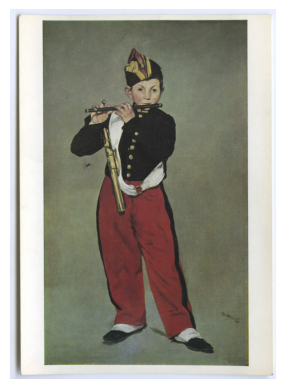

In [7]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.axis('off')

(-0.5, 862.5, 1199.5, -0.5)

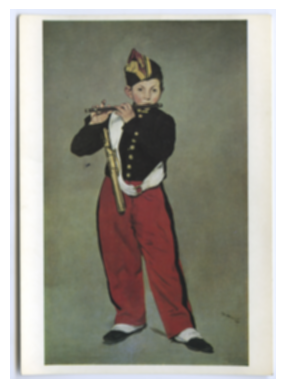

In [8]:
# aplicar filtros que homogenicen las imágenes
test = pre_process(images[0])
plt.imshow(test)
plt.axis('off')

# Procesamiento Median Cut

In [9]:
pc = PaletteCreator(method="median-cut")

In [10]:
import multiprocessing

def process_batch(batch):
    palette, proportions = pc.create_palette(batch)
    return palette, proportions

def process_images(images):
    results = [[], [], []]

    # Create a Pool of worker processes
    with multiprocessing.Pool(processes=10) as pool:
        # Map the function and iterable to the Pool of processes
        raw_results = pool.map(process_batch, images)
    
    for palette, proportions in raw_results:
        results[0].extend(palette)
        results[1].extend(proportions)

    return results

In [11]:
%%time
import os
import time
batch_size = 1300
final_results = [[], []]
for i in range(0, len(db["path_image"]), batch_size):
    start = i
    end = min(i + batch_size, len(db["path_image"]))
    print(len(db["path_image"][start:end]))
    images = DataLoader(db["path_image"][start:end], 120, pre_process) # cargar imagenes en una lista
    results = process_images(images)
    final_results[0].extend(results[0])
    final_results[1].extend(results[1])
    print(f"Processed images {start} to {end}")
    # time.sleep(1)

1238


100%|██████████| 120/120 [00:18<00:00,  6.59it/s]


Processed images 0 to 1238
CPU times: user 51 s, sys: 14.7 s, total: 1min 5s
Wall time: 1min 16s


In [12]:
len(final_results[0]), len(final_results[1])

(1238, 1238)

## Guardar resultados

In [14]:
save_results_to_db(db, f'{pc.method}+average-filter', final_results)
db.head()

,Unnamed: 0,filename,path_image,kmeans_palette,kmeans_proportions,median-cut_palette,median-cut_proportions,kmeans+bitcutting_palette,kmeans+bitcutting_proportions,median-cut+average-filter_palette,median-cut+average-filter_proportions,kmeans+average-filter_palette,kmeans+average-filter_proportions,pnn-mode+resize_palette,pnn-mode+resize_proportions,pnn-mean+resize_palette,pnn-mean+resize_proportions,median_cut_palette,median_cut_proportions
0,0,52e95bdbba05837f97424a3580258ffb.jpg,data/beatriz_gonzalez/52e95bdbba05837f97424a35...,"[[121, 126, 105], [235, 235, 233], [102, 105, ...","[0.2937311703360371, 0.26539011201235996, 0.25...","[[86, 74, 62], [110, 115, 98], [236, 236, 235]...","[0.2649957066804053, 0.2499656534432423, 0.241...","[[111, 119, 95], [231, 231, 231], [95, 103, 79...","[0.301753572808034, 0.2723281189648513, 0.1439...","[[86, 82, 71], [114, 102, 86], [236, 236, 234]...","[0.26539927872230806, 0.25093937832732266, 0.2...","[[105, 108, 89], [124, 128, 108], [241, 241, 2...","[0.2890845886442642, 0.27547605252993435, 0.16...","[[107, 108, 89], [222, 224, 225], [93, 95, 80]...","[0.49709401709401707, 0.23247863247863249, 0.1...","[[113.23968363136176, 116.95563961485557, 97.3...","[0.49709401709401707, 0.23247863247863249, 0.1...","[[86, 74, 62], [110, 115, 98], [236, 236, 235]...","[0.2649957066804053, 0.2499656534432423, 0.241..."
1,1,50d8cae4e67dd4e690d443cab7a88fe9.jpg,data/beatriz_gonzalez/50d8cae4e67dd4e690d443ca...,"[[4, 4, 6], [185, 183, 188], [206, 206, 212], ...","[0.6350989583333333, 0.14283958333333333, 0.10...","[[3, 3, 4], [195, 194, 200], [12, 10, 14], [17...","[0.5190302083333334, 0.23521770833333333, 0.12...","[[7, 7, 7], [191, 183, 191], [175, 167, 175], ...","[0.6063708333333333, 0.128721875, 0.1213552083...","[[3, 3, 4], [195, 194, 200], [160, 157, 161], ...","[0.5390625, 0.22832083333333333, 0.11601666666...","[[4, 4, 6], [180, 178, 183], [204, 204, 211], ...","[0.6154458333333334, 0.169159375, 0.118140625,...","[[3, 3, 4], [184, 183, 189], [203, 203, 210], ...","[0.5983333333333334, 0.2125, 0.096770833333333...","[[4.4735376044568245, 4.35149721448468, 5.6448...","[0.5983333333333334, 0.2125, 0.096770833333333...","[[3, 3, 4], [195, 194, 200], [12, 10, 14], [17...","[0.5190302083333334, 0.23521770833333333, 0.12..."
2,2,51e55522af0fcaa36ecfe6417b063512.jpg,data/beatriz_gonzalez/51e55522af0fcaa36ecfe641...,"[[199, 196, 198], [188, 184, 185], [6, 6, 7], ...","[0.39645416666666666, 0.199446875, 0.158172916...","[[201, 198, 200], [185, 180, 180], [4, 4, 5], ...","[0.4843791666666667, 0.253759375, 0.1368614583...","[[199, 191, 199], [207, 207, 207], [7, 7, 7], ...","[0.262128125, 0.21826979166666666, 0.158196875...","[[199, 197, 199], [183, 178, 179], [4, 4, 5], ...","[0.49727604166666667, 0.24363854166666668, 0.1...","[[197, 195, 197], [183, 179, 180], [6, 6, 6], ...","[0.423584375, 0.25050104166666665, 0.151398958...","[[200, 198, 200], [5, 5, 5], [175, 169, 171], ...","[0.7205208333333334, 0.13270833333333334, 0.11...","[[194.25068671389332, 191.0798033829695, 192.7...","[0.7205208333333334, 0.13270833333333334, 0.11...","[[201, 198, 200], [185, 180, 180], [4, 4, 5], ...","[0.4843791666666667, 0.253759375, 0.1368614583..."
3,3,3337155ae5bbb9da7ff1582e7d88c22f.JPG,data/beatriz_gonzalez/3337155ae5bbb9da7ff1582e...,"[[233, 233, 233], [235, 235, 235], [2, 2, 2], ...","[0.6509738714108894, 0.31586666848020745, 0.01...","[[221, 221, 221], [235, 235, 235], [226, 226, ...","[0.34206666575989625, 0.31586666848020745, 0.1...","[[231, 231, 231], [7, 7, 7], [31, 31, 31], [18...","[0.9664415609145687, 0.01228333854726314, 0.00...","[[225, 225, 225], [232, 232, 232], [230, 230, ...","[0.49575631452238134, 0.24787815726119067, 0.1...","[[233, 233, 233], [207, 207, 207], [183, 183, ...","[0.9053649070787031, 0.039200817906901886, 0.0...","[[234, 234, 234], [214, 214, 214], [195, 195, ...","[0.8964147946448832, 0.050941683685046514, 0.0...","[[233.15681559296291, 233.15681559296291, 233....","[0.89641479464488

In [41]:
db.to_csv(PATH_IMAGES_METADATA, index=False)

# Ejemplo de visualización

In [42]:
db = pd.read_csv(PATH_IMAGES_METADATA)

In [43]:
palette_img = db[f'{pc.method}+average_filter_palette'].values
proportions_img = db[f'{pc.method}+average_filter_proportions'].values

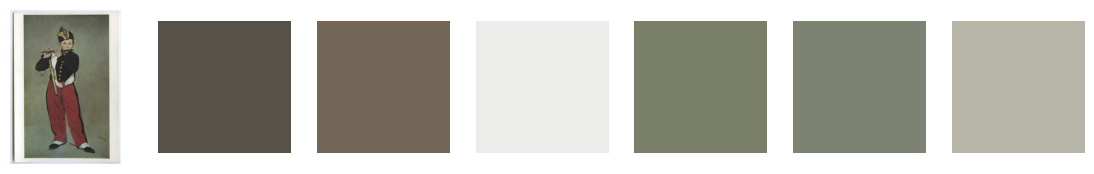

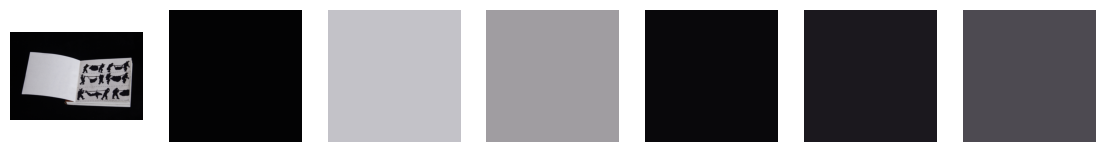

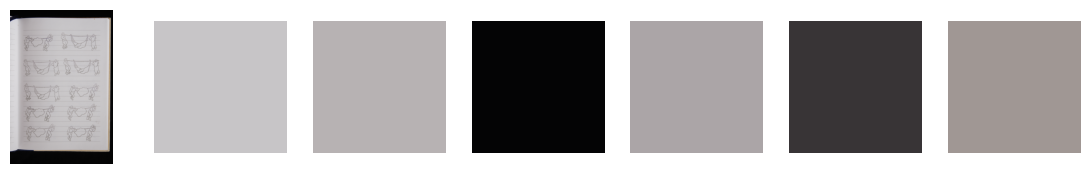

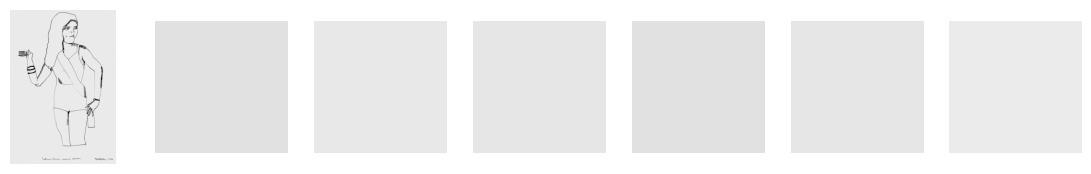

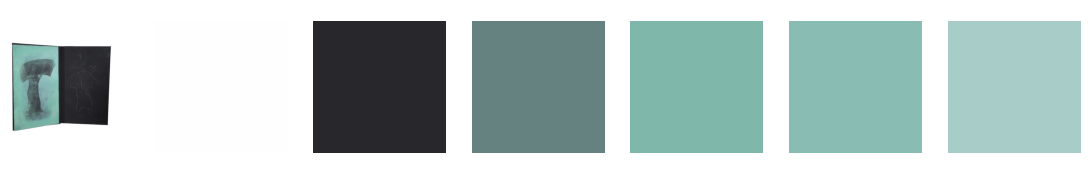

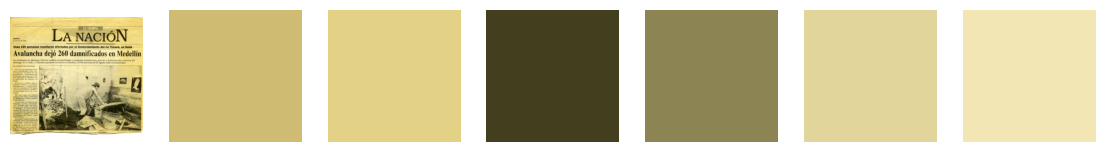

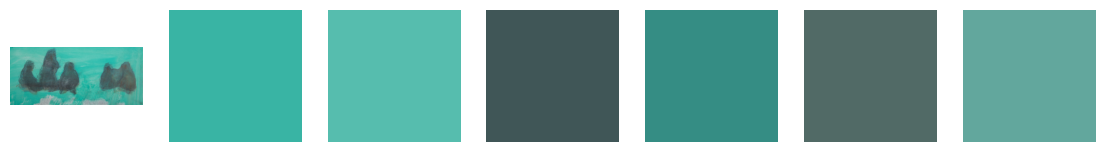

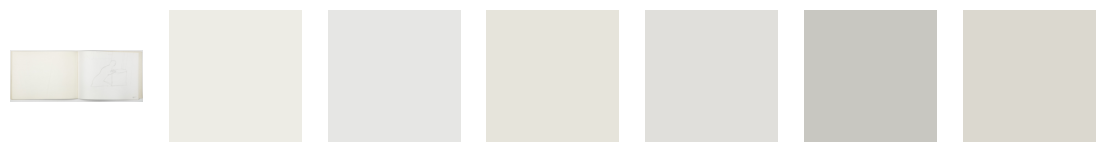

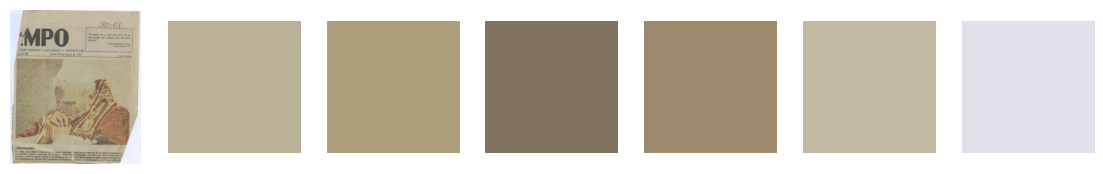

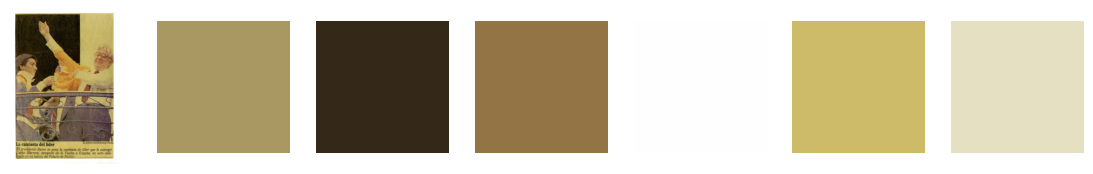

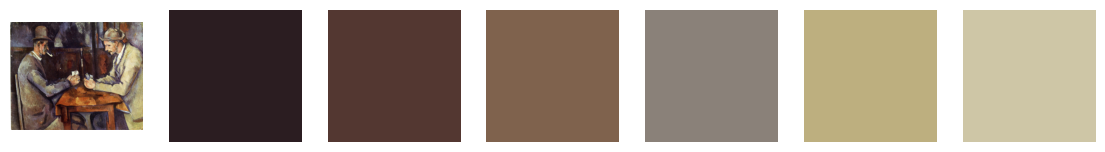

In [44]:
import ast
for i, image in enumerate(images[:11]):
    if image is not None:
        img_palette = ast.literal_eval(palette_img[i])
        show_palette(img_palette, img=image)